In [1]:
source("../shared.R")

Loading required package: coda
Linked to JAGS 4.3.0
Loaded modules: basemod,bugs


In [4]:
library("COUNT")
data("badhealth")

Loading required package: msme
Loading required package: MASS
Loading required package: lattice
Loading required package: sandwich


In [5]:
head(badhealth)

numvisit,badh,age
30,0,58
20,0,54
16,0,44
20,0,57
15,0,33
15,0,28


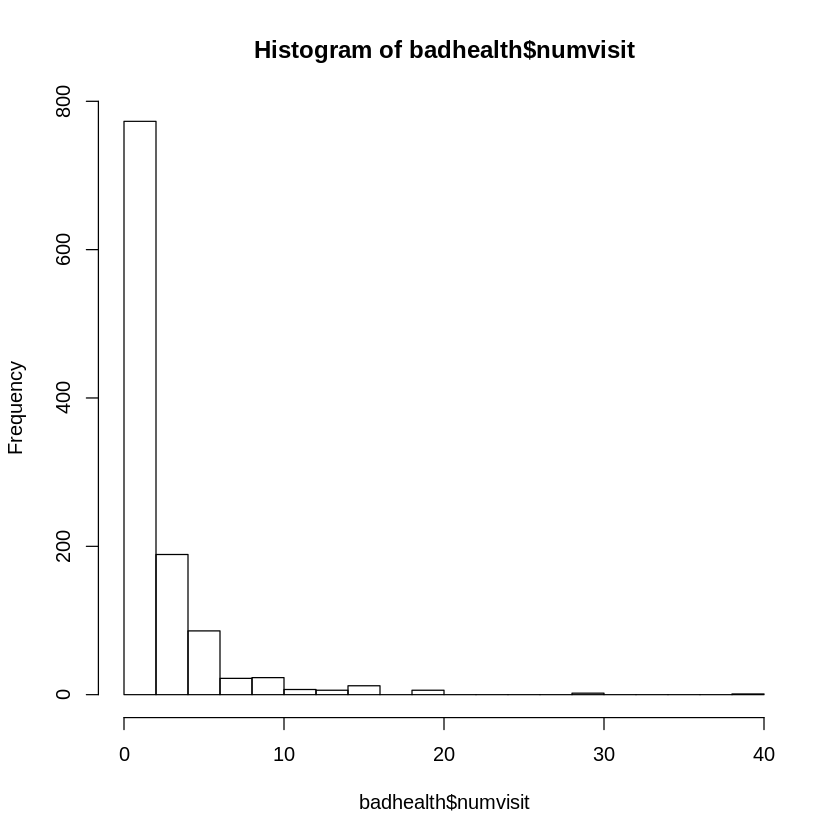

In [18]:
hist(badhealth$numvisit, breaks=20)

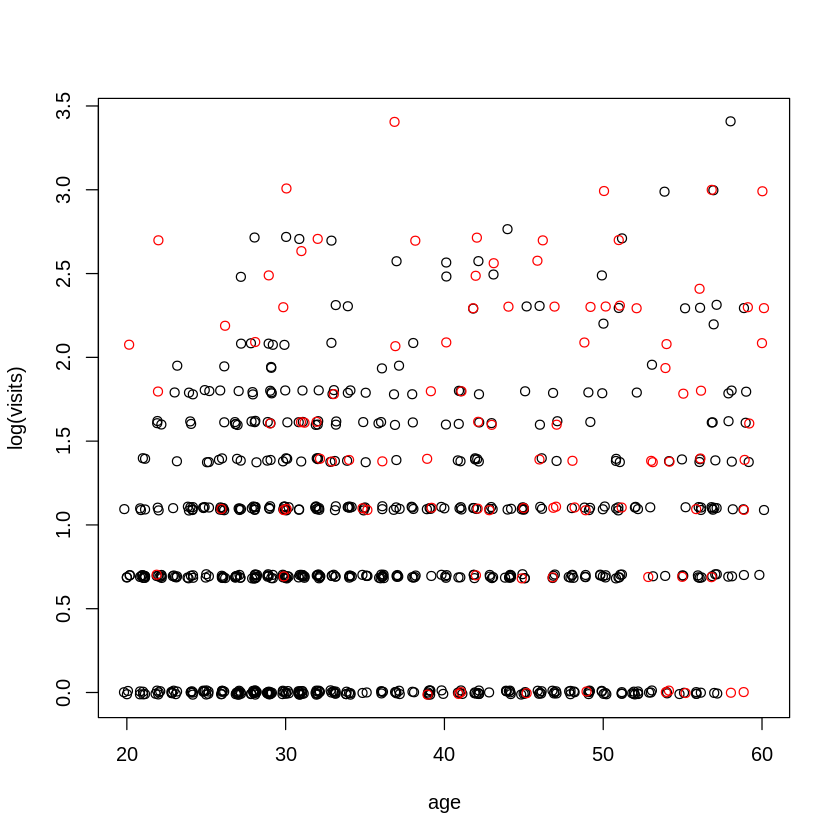

In [20]:
plot(jitter(log(numvisit)) ~ jitter(age), data=badhealth, subset=badh==0, xlab="age", ylab="log(visits)")
points(jitter(log(numvisit)) ~ jitter(age), data=badhealth, subset=badh==1, col="red")

In [8]:
str_mod = " model {
    for (i in 1: length(numvisit)) {
        numvisit[i] ~ dpois(lam[i])
        log(lam[i]) = int + b_badh*badh[i] + b_age*age[i] + b_intx*age[i]*badh[i]
    }    
    int ~ dnorm(0, 1e-6)
    b_badh ~ dnorm(0, 1e-6)
    b_age ~ dnorm(0, 1e-6)
    b_intx ~ dnorm(0, 1e-6)
} "

mod = jags_model_compile(str_mod, as.list(badhealth), burnout = 1e3 )

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 1127
   Unobserved stochastic nodes: 4
   Total graph size: 3661

Initializing model



In [16]:
params = c("int", "b_badh", "b_age", "b_intx")
modsamples  = jags_model_sample(mod, var_names_ = params, n_iter_ = 5e3)
moddiag = jags_model_diag(modsamples$samples)

In [63]:
dic1 = dic.samples(mod, n.iter = 5e3)

In [64]:
dic1

Mean deviance:  5630 
penalty 4.004 
Penalized deviance: 5634 

In [66]:
str_mod2 = " model {
    for (i in 1: length(numvisit)) {
        numvisit[i] ~ dpois(lam[i])
        log(lam[i]) = int + b_badh*badh[i] + b_age*age[i]
    }    
    int ~ dnorm(0, 1e-6)
    b_badh ~ dnorm(0, 1e-6)
    b_age ~ dnorm(0, 1e-6)
    b_intx ~ dnorm(0, 1e-6)
} "
data2 = list(numvisit = badhealth$numvisit, badh = badhealth$badh, age = badhealth$age)
mod2 = jags_model_compile(str_mod2, data2, burnout = 1e3 )

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 1127
   Unobserved stochastic nodes: 4
   Total graph size: 3584

Initializing model



In [67]:
dic2 = dic.samples(mod2, n.iter = 5e3)

In [76]:
dic2

Mean deviance:  5635 
penalty 2.87 
Penalized deviance: 5638 

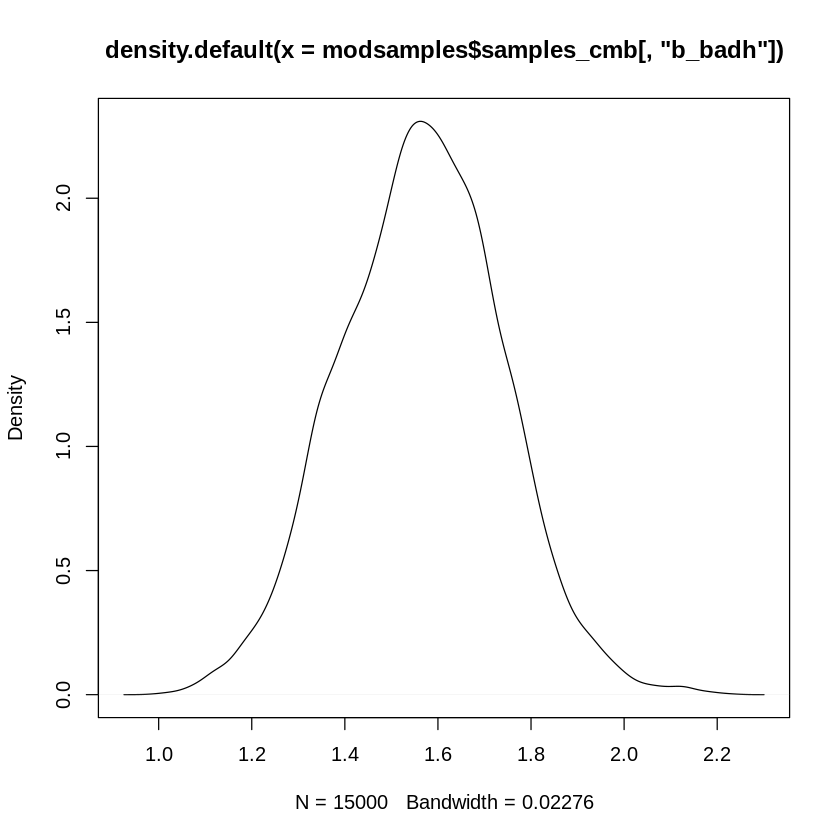

In [17]:
plot(density(modsamples$samples_cmb[,"b_badh"]))

## Model Checking

In [26]:
X = as.matrix(badhealth[,-1])
X = cbind(X, with(badhealth, badh*age))
head(X)

badh,age,
0,58,0
0,54,0
0,44,0
0,57,0
0,33,0
0,28,0


In [28]:
pmed_cff = apply(modsamples$samples_cmb, 2, median)
pmed_cff

b_age       b_badh       b_intx          int 
 0.008629282  1.566541442 -0.010891601  0.341690960

In [30]:
lam_hat = exp(pmed_cff['int'] + X %*% pmed_cff[c('b_badh', 'b_age', 'b_intx')])

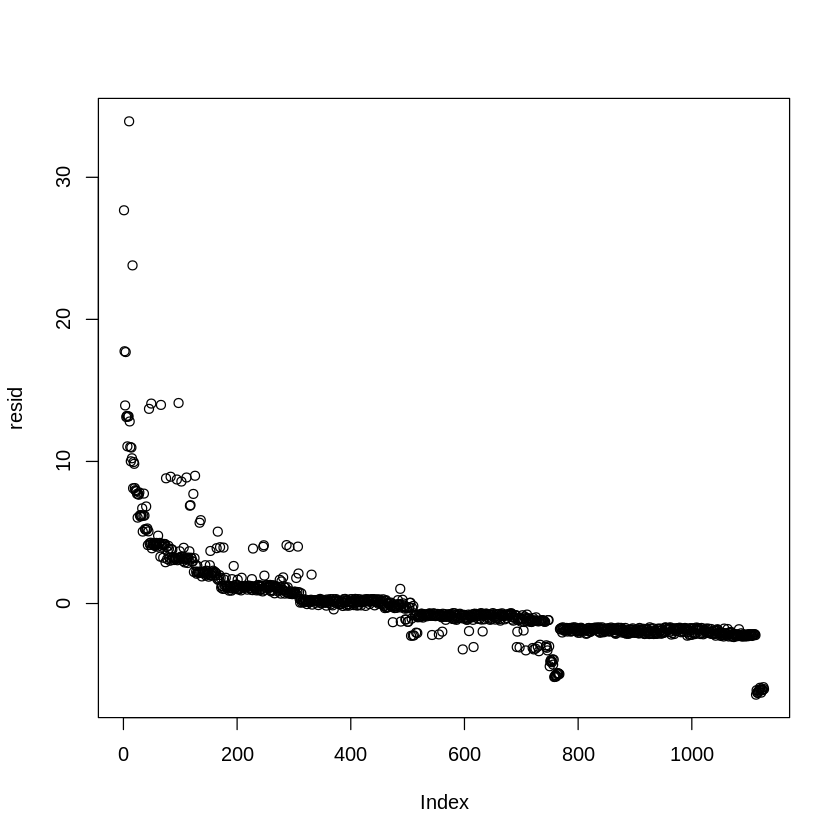

In [32]:
resid = badhealth$numvisit - lam_hat
plot(resid)

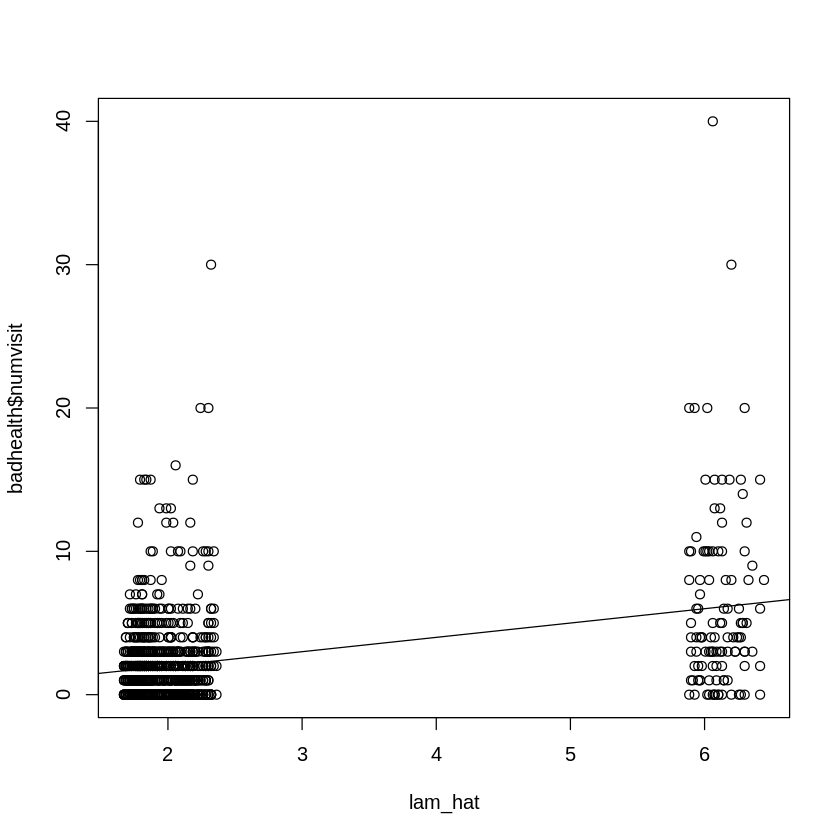

In [34]:
plot(lam_hat, badhealth$numvisit)
abline(0.0, 1.0)

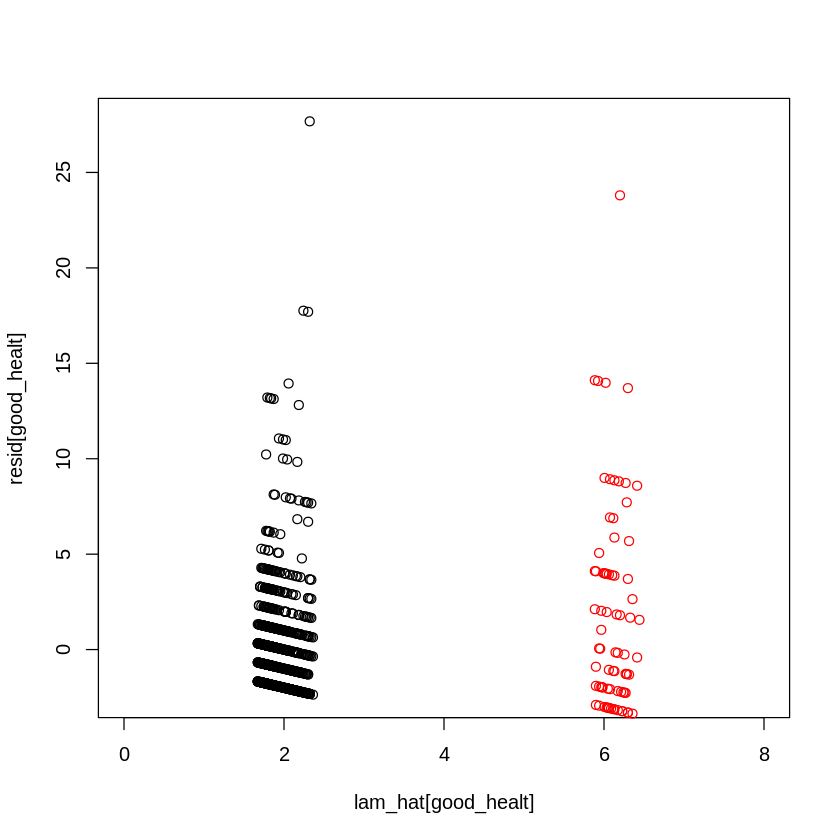

In [42]:
good_healt = which(badhealth$badh == 0)
bad_healt = which(badhealth$badh == 1)
plot(lam_hat[good_healt], resid[good_healt], xlim=c(0,8))
points(lam_hat[bad_healt], resid[bad_healt], col="red")

In [45]:
var(resid[good_healt]) # we expect the variance to be equal to poisson distr

[1] 7.022474

In [44]:
var(resid[bad_healt])

[1] 41.19623

In [47]:
summary(modsamples$samples_cmb)


Iterations = 1:15000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 15000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

            Mean       SD  Naive SE Time-series SE
b_age   0.008538 0.002062 1.684e-05      0.0001288
b_badh  1.564267 0.173016 1.413e-03      0.0129135
b_intx -0.010842 0.004010 3.274e-05      0.0002936
int     0.345187 0.080365 6.562e-04      0.0050693

2. Quantiles for each variable:

            2.5%       25%       50%       75%     97.5%
b_age   0.004319  0.007139  0.008629  0.009906  0.012511
b_badh  1.227419  1.444992  1.566541  1.682108  1.903155
b_intx -0.018689 -0.013575 -0.010892 -0.008133 -0.003086
int     0.190165  0.290674  0.341691  0.399693  0.508642


In [48]:
x1 = c(0, 35, 0)  # good health
x2 = c(1, 35, 35) # bad health

In [56]:
sim = modsamples$samples_cmb
n_sim = length(sim)
lam1 = exp( sim[, "int"] + sim[, c(2,1,3)] %*% x1)
lam2 = exp( sim[, "int"] + sim[, c(2,1,3)] %*% x2)

In [55]:
?rpois

In [57]:
y1 = rpois(n=n_sim, lambda = lam1)
y2 = rpois(n=n_sim, lambda = lam2)

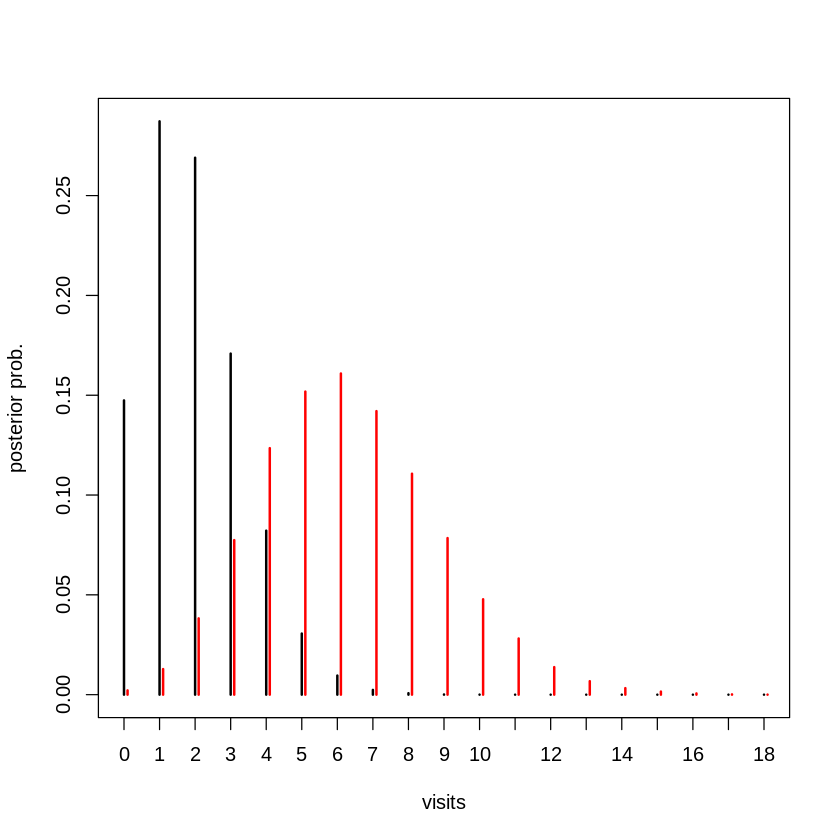

In [58]:
plot(table(factor(y1, levels=0:18))/n_sim, pch=2, ylab="posterior prob.", xlab="visits")
points(table(y2+0.1)/n_sim, col="red")

In [59]:
mean(y2 > y1)

[1] 0.9165333

In [60]:
exp(1.5 - 0.3*0.8 + 1.2)

[1] 11.70481

In [74]:
y = rpois(n = 1e6,lambda = 30) 

In [75]:
mean(y < 22)

[1] 0.054618